# Setup

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\n################################################################################\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Nov 23 15:53:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Setup

In [2]:
# Transformers installation
!pip install transformers datasets

# The Evaluate library provides a simple accuracy function
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.6 MB/s 
     |████████████████████████████████| 451 kB 60.5 MB/s 
     |████████████████████████████████| 182 kB 66.0 MB/s 
     |████████████████████████████████| 7.6 MB 49.0 MB/s 
     |████████████████████████████████| 115 kB 42.8 MB/s 
     |████████████████████████████████| 212 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 476 kB/s 


In [3]:
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=12aad63bf8a6a0f5f3cba917972f971a4db0f4ac3516c7aeedf89b47b9f87116
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

## Other

In [5]:
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pd.options.display.max_colwidth = 1000
pd.set_option('display.expand_frame_repr', False)

In [6]:
TOKEN_MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 5e-5
SEED_VALUE = 42
TEST_DATASET_SIZE = 1000
EVALUATE_AFTER_EPOCH = False

In [7]:
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

# Dataset Preparation

In [8]:
# IMDB dataset from https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb")

dataset["train"][100]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': "Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary.",
 'label': 0}

In [9]:
# Separate dataset
train_raw = dataset["train"].shuffle(seed=SEED_VALUE)
train_d_raw = train_raw.select(range(12500))
train_daux_raw = train_raw.select(range(12500, 25000))

test_raw = dataset["test"].shuffle(seed=SEED_VALUE)

In [10]:
# # Subsets - uncomment which set to use

# # Full D dataset
# train_dataset = train_d_raw
# eval_dataset = test_raw

# Full D_aux dataset
train_dataset = train_daux_raw
eval_dataset = test_raw

# # Smaller datasets for testing
# train_dataset = train_d_raw.select(range(TEST_DATASET_SIZE))
# eval_dataset = test_raw.select(range(TEST_DATASET_SIZE))

print("Train dataset positive: {}/{}".format(np.sum(train_dataset['label']), train_dataset.num_rows))
print("Eval dataset positive: {}/{}".format(np.sum(eval_dataset['label']), eval_dataset.num_rows))

Train dataset positive: 6267/12500
Eval dataset positive: 12500/25000


In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=TOKEN_MAX_LENGTH)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [13]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format("torch")

tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(["text"])
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("label", "labels")
tokenized_eval_dataset.set_format("torch")

In [14]:
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=BATCH_SIZE)

<a id='trainer'></a>

# BERT Training

## Prepare training settings

In [15]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_hidden_states = True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

In [17]:
num_training_steps = EPOCHS * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

## Visualizations

In [19]:
# dim_reducer = TSNE(n_components=2)
dim_reducer = PCA(n_components=2)

def visualize_layerwise_embeddings(hidden_states, masks, ys, epoch, title, layers_to_visualize=[0,1,2,3,8,9,10,11]):
    print('visualize_layerwise_embeddings for', title, 'epoch', epoch)
    global dim_reducer
    !mkdir -p tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6
    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]
    ys = ys.numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):
        layer_hidden_states = hidden_states[layer_i].cpu()
        averaged_layer_hidden_states = torch.div(layer_hidden_states, masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
        df.label = df.label.astype(int)
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])
        fig.suptitle(f"{title}: epoch {epoch}")
        ax[i].set_title(f"layer {layer_i+1}")
    plt.savefig(f'tmp/plots/{title}/{epoch}.png',format='png',pad_inches=0)
    print()

## Train Model

In [20]:
metric = evaluate.load("accuracy")
def evaluate_model(e_model, e_dataloader):
  e_progress_bar = tqdm(range(len(e_dataloader)))
  e_model.eval()
  e_total_loss = 0
  e_count = 0
  for batch in e_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = e_model(**batch)

      e_logits = outputs.logits
      e_count += batch['labels'].shape[0]
      e_total_loss += outputs.loss.detach() * batch['labels'].shape[0]
      predictions = torch.argmax(e_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      e_progress_bar.update(1)

  e_acc = metric.compute()['accuracy']
  e_loss = e_total_loss / e_count
  return e_acc, e_loss

In [21]:
def visualize_model(v_model, v_dataloader, text=""):
  print("  Visualizing...")
  v_progress_bar = tqdm(range(len(v_dataloader)))
  v_model.eval()
  mem_report()

  v_total_loss = 0
  v_count = 0
  v_masks = torch.zeros(0, TOKEN_MAX_LENGTH)
  v_ys = torch.zeros(0,1)
  v_hidden_states = None
  for batch in v_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = v_model(**batch)

      v_logits = outputs.logits
      v_count += batch['labels'].shape[0]
      v_total_loss += outputs.loss.detach() * batch['labels'].shape[0]

      hidden_states = outputs.hidden_states[1:]
      v_masks = torch.cat([v_masks, batch["attention_mask"].cpu()])
      v_ys = torch.cat([v_ys, batch['labels'].cpu().view(-1,1)])

      if type(v_hidden_states) == type(None):
          v_hidden_states = tuple(layer_hidden_states.sum(dim=1) for layer_hidden_states in hidden_states)
      else:
          v_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.sum(dim=1)]) for layer_hidden_state_all,layer_hidden_state_batch in zip(v_hidden_states,hidden_states))

      predictions = torch.argmax(v_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      v_progress_bar.update(1)

  visualize_layerwise_embeddings(v_hidden_states, v_masks, v_ys, epoch, text)
  v_loss = v_total_loss / v_count
  v_acc = metric.compute()['accuracy']
  
  torch.cuda.empty_cache()
  mem_report()

  return v_acc, v_loss


Epoch 0
  Visualizing...


  0%|          | 0/1563 [00:00<?, ?it/s]

CPU RAM Free: 11.3 GB
GPU 0 ... Mem Free: 14029MB / 15109MB | Utilization   7%
visualize_layerwise_embeddings for train_data epoch 0

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 13271MB / 15109MB | Utilization  12%

Epoch 1
  Training...


  0%|          | 0/1563 [00:00<?, ?it/s]

  Visualizing...


  0%|          | 0/1563 [00:00<?, ?it/s]

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 10349MB / 15109MB | Utilization  32%
visualize_layerwise_embeddings for train_data epoch 1

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 11677MB / 15109MB | Utilization  23%

Epoch 2
  Training...


  0%|          | 0/1563 [00:00<?, ?it/s]

  Visualizing...


  0%|          | 0/1563 [00:00<?, ?it/s]

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 10261MB / 15109MB | Utilization  32%
visualize_layerwise_embeddings for train_data epoch 2

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 11733MB / 15109MB | Utilization  22%

Epoch 3
  Training...


  0%|          | 0/1563 [00:00<?, ?it/s]

  Visualizing...


  0%|          | 0/1563 [00:00<?, ?it/s]

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 10269MB / 15109MB | Utilization  32%
visualize_layerwise_embeddings for train_data epoch 3

CPU RAM Free: 11.2 GB
GPU 0 ... Mem Free: 11721MB / 15109MB | Utilization  22%


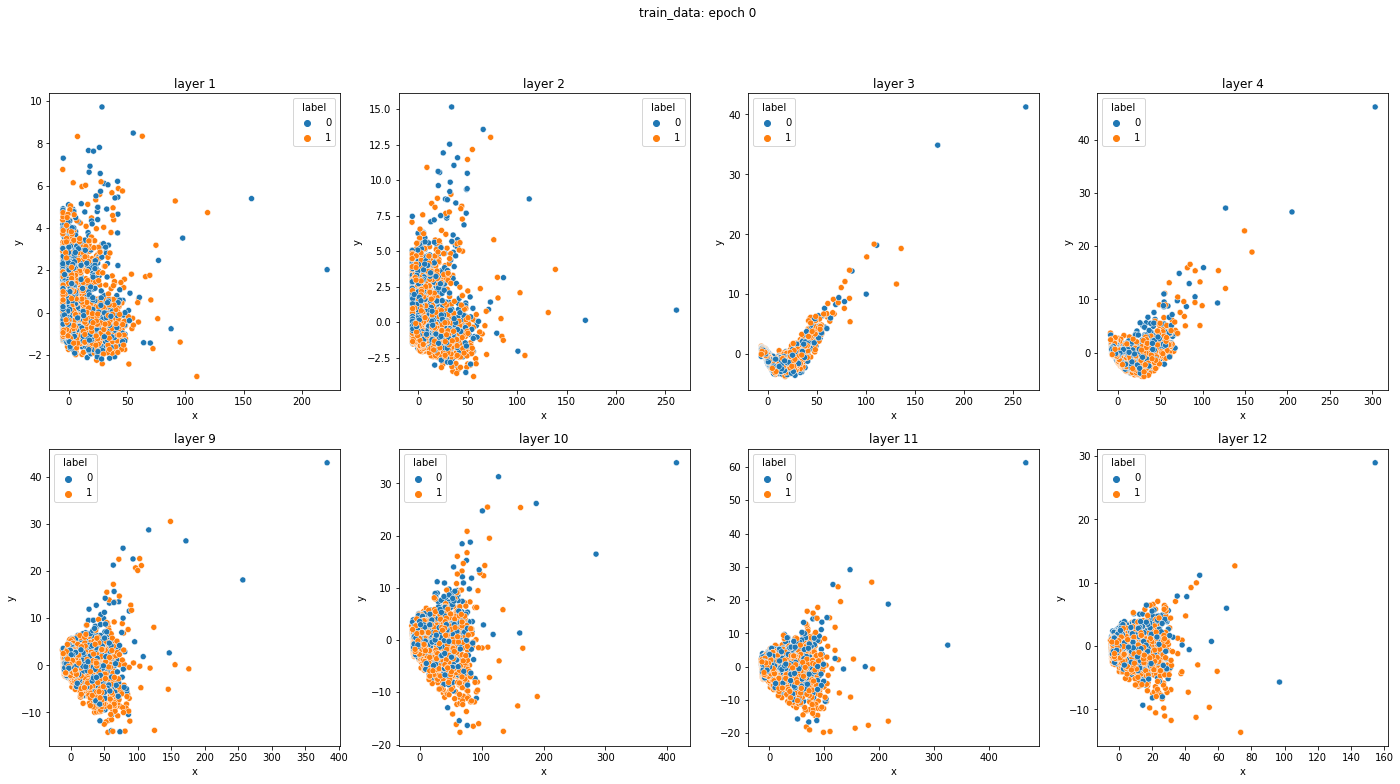

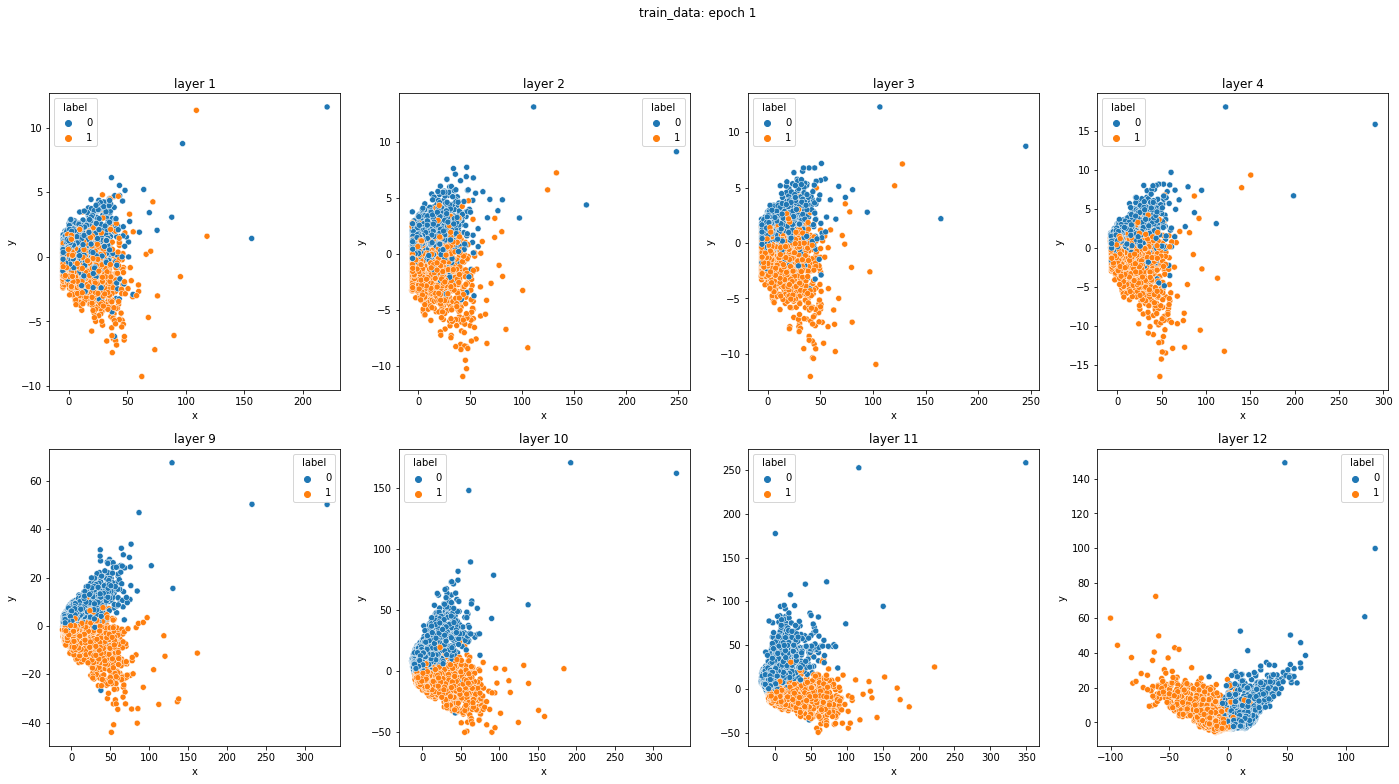

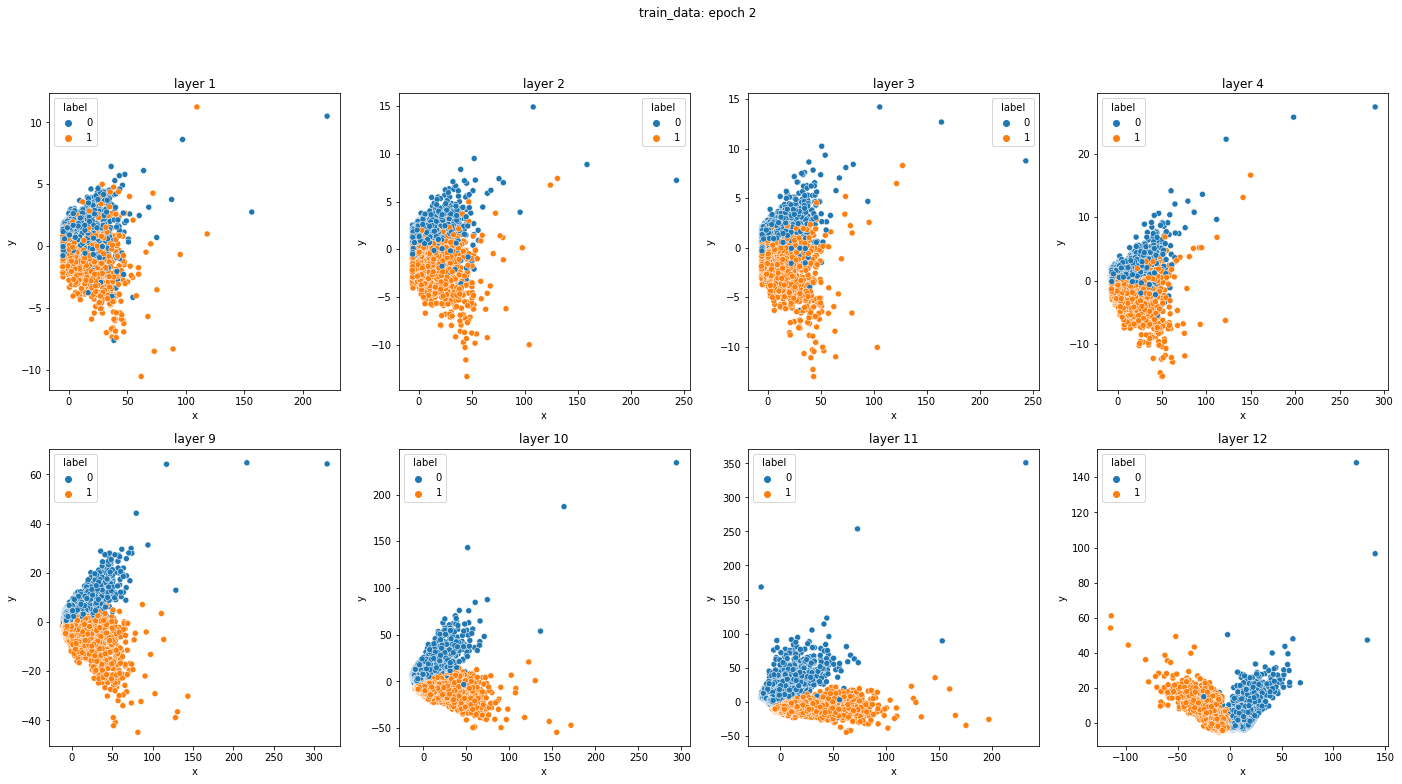

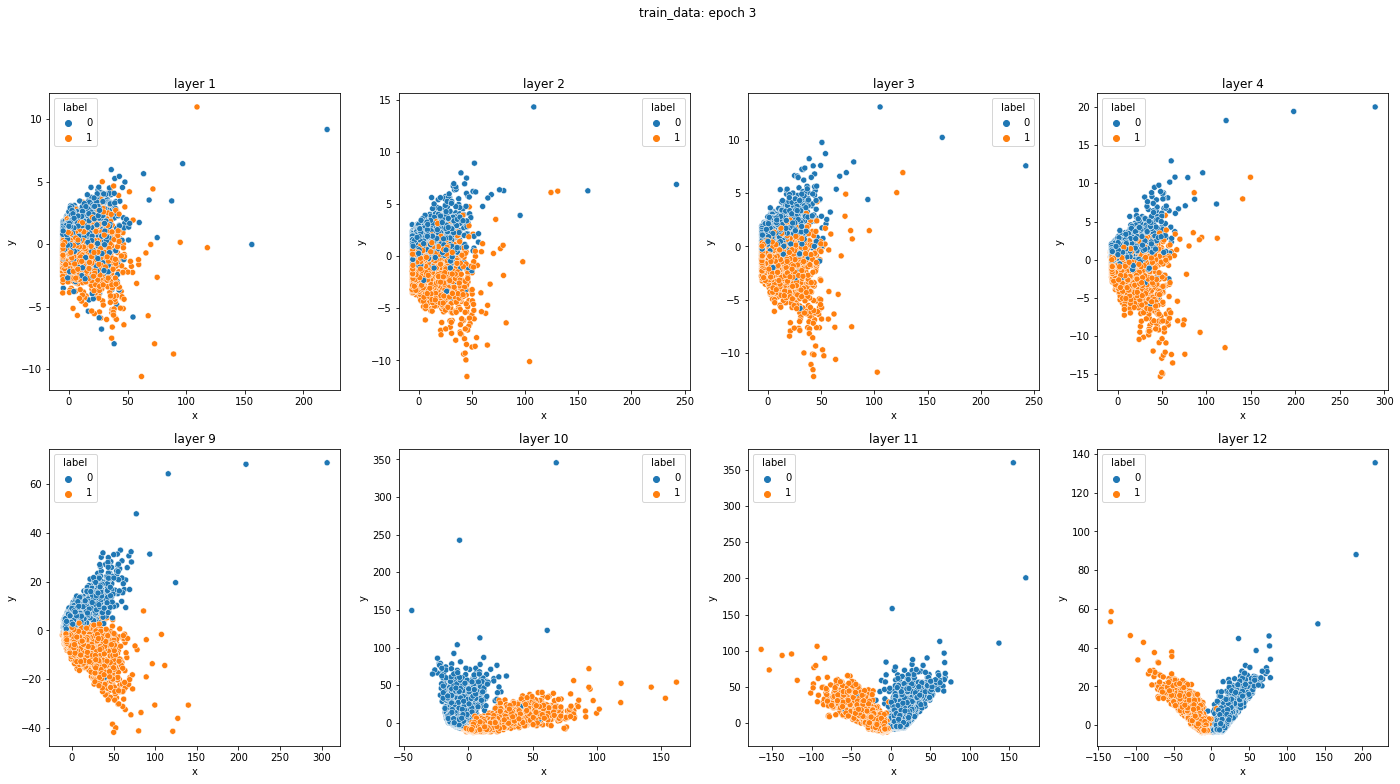

In [22]:
for epoch in range(EPOCHS+1):
    print("\nEpoch {}".format(epoch))
    if epoch != 0:
      print("  Training...")
      progress_bar = tqdm(range(len(train_dataloader)))
      model.train()
      for batch in train_dataloader:
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          loss = outputs.loss
          loss.backward()

          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()
          progress_bar.update(1)
      
    _, _ = visualize_model(model, train_dataloader, "train_data")
    if EVALUATE_AFTER_EPOCH:
      print("  Evaluating...")
      acc, loss = visualize_model(model, eval_dataloader, "eval_data")
      print("  Accuracy: {}".format(acc))
      print("  Loss: {}".format(loss))

In [23]:
print(evaluate_model(model, eval_dataloader))

  0%|          | 0/3125 [00:00<?, ?it/s]

(0.912, tensor(0.3223, device='cuda:0'))


## Save model weights

In [24]:
model.save_pretrained("bert_imdb_viz")

In [25]:
!zip -r plots.zip tmp/plots

  adding: tmp/plots/ (stored 0%)
  adding: tmp/plots/train_data/ (stored 0%)
  adding: tmp/plots/train_data/2.png (deflated 3%)
  adding: tmp/plots/train_data/1.png (deflated 3%)
  adding: tmp/plots/train_data/0.png (deflated 3%)
  adding: tmp/plots/train_data/3.png (deflated 3%)


In [26]:
!zip -r bert_imdb_viz_model.zip bert_imdb_viz

  adding: bert_imdb_viz/ (stored 0%)
  adding: bert_imdb_viz/pytorch_model.bin (deflated 7%)
  adding: bert_imdb_viz/config.json (deflated 49%)


<a id='keras'></a>